The code uses a logistic regression and probit model to predict customer subscription to a term deposit based on various features. It includes data preprocessing, model fitting, cross-validation, and interpretation of results.
logisitic regression was used for the same to ensure interpretability of the model which is crucial for the business. 

after doing the regressions with the day and without day variable. It was found that the model with day and without day variable has a 1 point difference in their recall, precision and f1 score. Hence the model without the 
day variable is preferred as it is more logical in the interpretation of the model. The model acheived a 92.58% and recall of 57.49% which is good for the buisiness. Recall is emphasized over here as its formula looks at false negatives
which is crucial for the business as foregoing potential 'yes' customer is more costly than calling a 'no' customer (which are false poisitives and in precision metric).

the model finds that retired customers have a 1.78% higher probability of subscribing to a term deposit compared to other job type customers, holding all other factors constant. Similary customers who are in teritary education have a 1.43% higher probability
of subscribing to a term deposit compared to other education level customers, holding all other factors constant. Retired customers generally have more free time and may be more interested in investment opportunities, while those with tertiary education may have a better understanding of financial products and their benefits. 
Moreover retired customers have a more stable financial situation and are more comfortable investing in term deposits. Tertiary educated customers might want a source of income that gives them returns in short term with low risk, which a term deposit provides.

In months, customers contacted in march have a 17.49% higher probability of subscribing to a term deposit compared to other months, holding all other factors constant. Similarly customers contacted in november have a 11.63% higher probability of subscribing to a term deposit compared to other months, holding all other factors constant. 
customers contacted on october have a 33.83% higher probability of subscribing to a term deposit compared to other months, holding all other factors constant. The rationale behind this is the covid pandemic, in march the same was announced and people were looking for safe investment options compared to stocks and mutual funds which were volatile at that time. 
In october, the second wave of covid hit and people again looked for safe investment options. These reasons explain the high subscription rates in these months.

the excercise also looks at the case where the company wants to predict customers who will subscribe to a term deposit prior to calling them. Here predicted probabilities of every customer were calculated and then sorted in descending order and the top 1% (this number is subject to change based on resources of the company) were selected to be called. The day, duration and campaign
are not available before calling, hence they have been removed from the dataset to avoid data leakage. This model is good for understanding the factors influencing customer subscription without the bias of post-contact information.



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB
None
            count         mean          std     min    25%    50%     75%  \
age       40000.0    40.544600     9.641776    19.0   33.0   39.0    48.0   
balance   40000.0  1274.277550  2903.769716 -8019.0   54.0

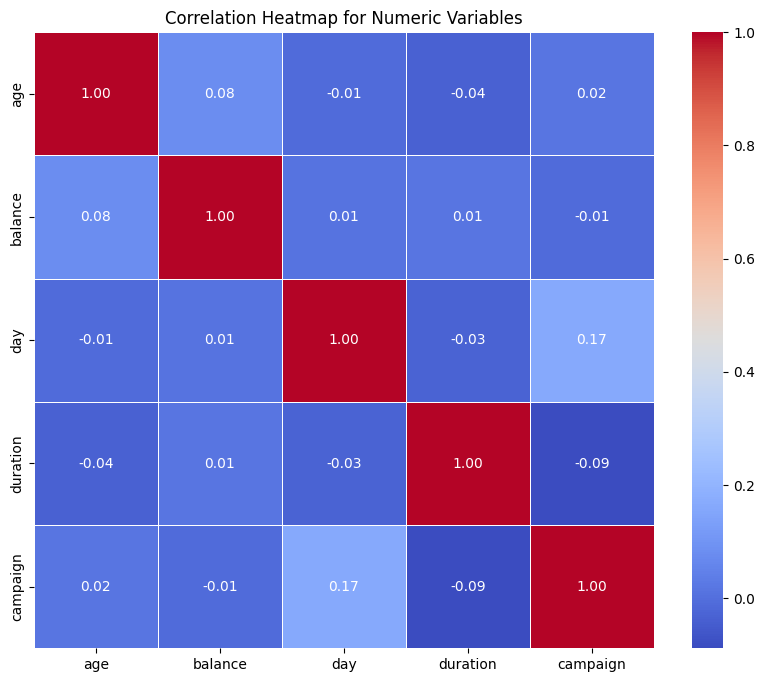


=== FULL-SAMPLE REGRESSION RESULTS ===

--- LOGIT MODEL ---
AIC: 13431.7209
BIC: 13749.7963
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                40000
Model:                          Logit   Df Residuals:                    39963
Method:                           MLE   Df Model:                           36
Date:                Sat, 08 Nov 2025   Pseudo R-squ.:                  0.3573
Time:                        13:35:00   Log-Likelihood:                -6678.9
converged:                       True   LL-Null:                       -10392.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -3.1687      0.211    -15.000      0.000      -3.583      -2.755
age        

In [ ]:
#importing necessary libraries
import pandas as pd
import numpy as np
import warnings
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, log_loss,
    f1_score, precision_score, recall_score
)

#first model of logistic regression with day variable included.

data  = pd.read_csv('/Users/sarvagyasharma/Desktop/apziva projects/second project/term-deposit-marketing-2020.csv')

#This part aims to understand the data by doing basic checks and descriptions. Moreover it also checks for any missing values and replaces them accordingly.
#to ensure the code can run without errors.

#data description
print(data.info())
#numeric data description
print(data.describe().T)
#categorical data description
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'y']
print(data[categorical_cols].describe().T)

#checking for missing values and if any exist replacing them with median for numeric columns and mode for categorical columns.
for col in data.columns:
    missing_count = data[col].isnull().sum()
    
    if missing_count > 0:
        if pd.api.types.is_numeric_dtype(data[col]):
            median_value = data[col].median()
            data[col].fillna(median_value, inplace=True)
            print(f"{col}: {missing_count} missing values replaced with median ({median_value})")
        else:
            mode_value = data[col].mode()[0]
            data[col].fillna(mode_value, inplace=True)
            print(f"{col}: {missing_count} missing values replaced with mode ('{mode_value}')")
    else:
        print(f"{col}: No missing value")
        

#preparing a correlation matrix to understand relationships between numeric variables and check for multicollinearity.

# Select only numeric columns (integer or float)
numeric_data = data.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
corr_matrix = numeric_data.corr()

# Display correlation matrix
print("CORRELATION MATRIX")
print(corr_matrix)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap for Numeric Variables')
plt.show()

#running logisitic regression to predict the target variable 'y' based on the other features in the dataset (logit and probit models with robusteness).

THRESHOLD = 0.2  # decision threshold for YES in logisitic regression

# target to 0/1
if data['y'].dtype == object:
    data['y'] = data['y'].astype(str).str.strip().str.lower().map({'yes': 1, 'no': 0})
vals = set(data['y'].dropna().unique())
if not vals.issubset({0, 1}):
    raise ValueError(f"Target y must be binary 0/1, found {vals}")
y = data['y'].astype(int)

# dtypes
num_cols = data.select_dtypes(include=['number']).columns.tolist()
if 'y' in num_cols:
    num_cols.remove('y')
cat_cols = data.select_dtypes(exclude=['number']).columns.tolist()

# Encoding the categorical variables using one-hot encoding.
X_num = data[num_cols].astype(float) if num_cols else pd.DataFrame(index=data.index)
X_cat = pd.get_dummies(data[cat_cols], drop_first=True, dtype=float) if cat_cols else pd.DataFrame(index=data.index)
X = pd.concat([X_num, X_cat], axis=1)
X = sm.add_constant(X, has_constant='add')

# clean
X = X.replace([np.inf, -np.inf], np.nan).astype(float)
keep = ~X.isnull().any(axis=1) & ~y.isnull()
X, y = X.loc[keep], y.loc[keep]

# identify binary dummy columns vs numeric for interpretation later
def is_binary_series(s: pd.Series) -> bool:
    vals = pd.Series(s.dropna().unique())
    if len(vals) <= 2:
        return set(np.sort(vals.values).tolist()).issubset({0.0, 1.0})
    return False

binary_cols = [c for c in X.columns if c != 'const' and is_binary_series(X[c])]
numeric_cols_for_effects = [c for c in X.columns if c not in binary_cols and c != 'const']

#helpers
def fit_sm_binary(model_type, X_df, y_series):
    if model_type == 'logit':
        model = sm.Logit(y_series, X_df)
    elif model_type == 'probit':
        model = sm.Probit(y_series, X_df)
    else:
        raise ValueError("model_type must be 'logit' or 'probit'")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res = model.fit(disp=0)
    return res

def cv_with_threshold(model_type, X_df, y_series, n_splits=5, threshold=THRESHOLD, seed=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    metrics = {'accuracy': [], 'roc_auc': [], 'log_loss': [], 'f1': [], 'precision': [], 'recall': []}
    for tr, te in skf.split(X_df, y_series):
        X_tr, X_te = X_df.iloc[tr], X_df.iloc[te]
        y_tr, y_te = y_series.iloc[tr], y_series.iloc[te]
        model = sm.Logit(y_tr, X_tr) if model_type == 'logit' else sm.Probit(y_tr, X_tr)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            try:
                res = model.fit(disp=0)
            except Exception:
                continue
        proba = res.predict(X_te)
        proba = np.clip(proba, 1e-6, 1 - 1e-6)
        pred = (proba >= threshold).astype(int)
        metrics['accuracy'].append(accuracy_score(y_te, pred))
        try:
            metrics['roc_auc'].append(roc_auc_score(y_te, proba))
        except ValueError:
            pass
        metrics['log_loss'].append(log_loss(y_te, proba))
        metrics['f1'].append(f1_score(y_te, pred, zero_division=0))
        metrics['precision'].append(precision_score(y_te, pred, zero_division=0))
        metrics['recall'].append(recall_score(y_te, pred, zero_division=0))
    return {k: {'mean': np.mean(v), 'std': np.std(v)} for k, v in metrics.items() if len(v) > 0}

#results
print("\n=== FULL-SAMPLE REGRESSION RESULTS ===")
results = {}
for model_name in ['logit', 'probit']:
    res = fit_sm_binary(model_name, X, y)
    results[model_name] = res
    print(f"\n--- {model_name.upper()} MODEL ---")
    print(f"AIC: {res.aic:.4f}")
    print(f"BIC: {res.bic:.4f}")
    print(res.summary())

#5-fold cross validation at threshold.
print(f"\n=== 5-FOLD CROSS VALIDATION (Threshold = {THRESHOLD}) ===")
for model_name in ['logit', 'probit']:
    cvres = cv_with_threshold(model_name, X, y, n_splits=5, threshold=THRESHOLD)
    print(f"\n--- {model_name.upper()} MODEL ---")
    for metric, stats in cvres.items():
        print(f"{metric}: mean={stats['mean']:.4f}  std={stats['std']:.4f}")

#intepretation in percentage points for PROBIT only as lower aic and sic than logit.
def average_discrete_effect_for_dummy(res, X_df, varname):
    X0 = X_df.copy()
    X1 = X_df.copy()
    X0[varname] = 0.0
    X1[varname] = 1.0
    p0 = res.predict(X0)
    p1 = res.predict(X1)
    return float((p1 - p0).mean())  # fraction

def print_interpretation_probit(res):
    print("\n=== INTERPRETATION IN PERCENTAGES (PROBIT) ===")
    # significant variables at p < 0.10
    pvals = res.pvalues
    sig_vars = [v for v in pvals.index if v != 'const' and pvals[v] < 0.10]
    if not sig_vars:
        print("No coefficients are significant at p < 0.10")
        return

    # numeric average marginal effects
    ame_map = {}
    try:
        mfx = res.get_margeff(at='overall', method='dydx')
        mf = mfx.summary_frame()
        if 'variable' in mf.columns:
            mf = mf.set_index('variable')
        # dy/dx is the column with marginal effects
        col = 'dy/dx' if 'dy/dx' in mf.columns else mf.columns[0]
        for v in numeric_cols_for_effects:
            if v in mf.index:
                ame_map[v] = float(mf.loc[v, col])  # fraction per +1 unit
    except Exception:
        pass

    rows = []
    for v in sig_vars:
        pval = float(pvals[v])
        if v in binary_cols:
            eff_pp = average_discrete_effect_for_dummy(res, X, v) * 100.0
            rows.append((v, 'binary 0→1', eff_pp, pval))
        elif v in numeric_cols_for_effects:
            if v in ame_map and np.isfinite(ame_map[v]):
                eff_pp = ame_map[v] * 100.0
                rows.append((v, 'numeric per +1', eff_pp, pval))
            else:
                rows.append((v, 'numeric per +1', float('nan'), pval))
        else:
            rows.append((v, 'unknown', float('nan'), pval))

    if rows:
        print("Variable".ljust(28), "Type".ljust(16), "Avg change in prob (pp)".ljust(24), "p-value")
        print("-"*85)
        for name, typ, pp, p in rows:
            pp_str = f"{pp:.2f}" if np.isfinite(pp) else "NA"
            print(name.ljust(28), typ.ljust(16), pp_str.ljust(24), f"{p:.3f}")

# print interpretation for PROBIT only
print_interpretation_probit(results['probit'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB
None
            count         mean          std     min    25%    50%     75%  \
age       40000.0    40.544600     9.641776    19.0   33.0   39.0    48.0   
balance   40000.0  1274.277550  2903.769716 -8019.0   54.0

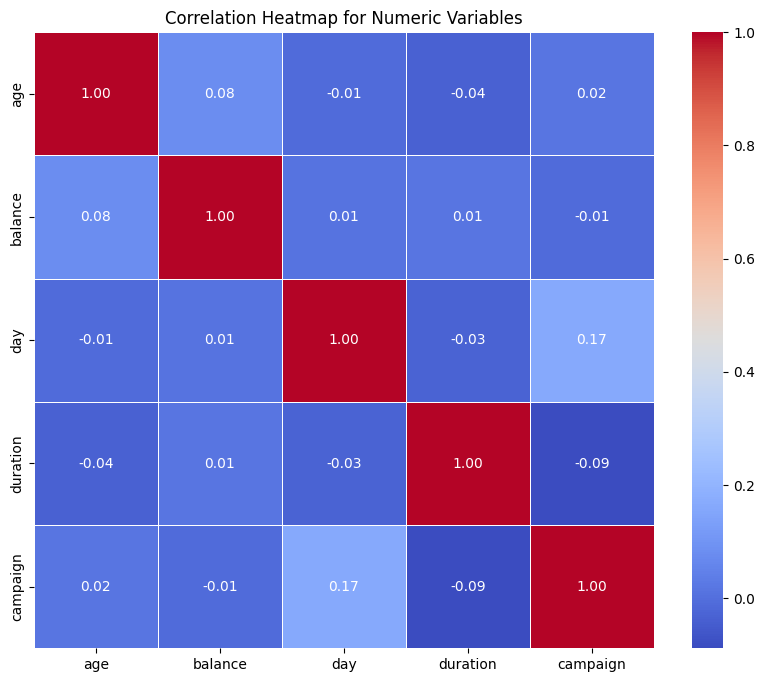


=== FULL-SAMPLE REGRESSION RESULTS ===

--- LOGIT MODEL ---
AIC: 13522.4886
BIC: 13831.9674
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                40000
Model:                          Logit   Df Residuals:                    39964
Method:                           MLE   Df Model:                           35
Date:                Sat, 08 Nov 2025   Pseudo R-squ.:                  0.3529
Time:                        13:36:46   Log-Likelihood:                -6725.2
converged:                       True   LL-Null:                       -10392.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.4808      0.197    -12.610      0.000      -2.866      -2.095
age        

In [2]:
#importing necessary libraries
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, log_loss,
    f1_score, precision_score, recall_score
)

#second model of logistic regression with day variable not included.

data  = pd.read_csv('/Users/sarvagyasharma/Desktop/apziva projects/second project/term-deposit-marketing-2020.csv')

#Basic data understanding
print(data.info())
print(data.describe().T)

#This part aims to understand the data by doing basic checks and descriptions. Moreover it also checks for any missing values and replaces them accordingly.
#to ensure the code can run without errors.

#data description
print(data.info())
#numeric data description
print(data.describe().T)
#categorical data description
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'y']
print(data[categorical_cols].describe().T)

#checking for missing values and if any exist replacing them with median for numeric columns and mode for categorical columns.
for col in data.columns:
    missing_count = data[col].isnull().sum()
    
    if missing_count > 0:
        if pd.api.types.is_numeric_dtype(data[col]):
            median_value = data[col].median()
            data[col].fillna(median_value, inplace=True)
            print(f"{col}: {missing_count} missing values replaced with median ({median_value})")
        else:
            mode_value = data[col].mode()[0]
            data[col].fillna(mode_value, inplace=True)
            print(f"{col}: {missing_count} missing values replaced with mode ('{mode_value}')")
    else:
        print(f"{col}: No missing value")
        

#preparing a correlation matrix to understand relationships between numeric variables and check for multicollinearity.

# Select only numeric columns (integer or float)
numeric_data = data.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
corr_matrix = numeric_data.corr()

# Display correlation matrix
print("CORRELATION MATRIX")
print(corr_matrix)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap for Numeric Variables')
plt.show()

#running logisitic regression to predict the target variable 'y' based on the other features in the dataset (logit and probit models with robusteness).

# target to 0/1
if data['y'].dtype == object:
    data['y'] = data['y'].astype(str).str.strip().str.lower().map({'yes': 1, 'no': 0})
vals = set(data['y'].dropna().unique())
if not vals.issubset({0, 1}):
    raise ValueError(f"Target y must be binary 0/1, found {vals}")
y = data['y'].astype(int)

# dtypes
num_cols = data.select_dtypes(include=['number']).columns.tolist()
if 'y' in num_cols:
    num_cols.remove('y')
cat_cols = data.select_dtypes(exclude=['number']).columns.tolist()

# Remove 'day' if present
if 'day' in num_cols:
    num_cols.remove('day')
if 'day' in data.columns:
    data = data.drop(columns=['day'])

# Encoding the categorical variables using one-hot encoding.
X_num = data[num_cols].astype(float) if num_cols else pd.DataFrame(index=data.index)
X_cat = pd.get_dummies(data[cat_cols], drop_first=True, dtype=float) if cat_cols else pd.DataFrame(index=data.index)
X = pd.concat([X_num, X_cat], axis=1)
X = sm.add_constant(X, has_constant='add')

# clean
X = X.replace([np.inf, -np.inf], np.nan).astype(float)
keep = ~X.isnull().any(axis=1) & ~y.isnull()
X, y = X.loc[keep], y.loc[keep]

# identify binary dummy columns vs numeric for interpretation later
def is_binary_series(s: pd.Series) -> bool:
    vals = pd.Series(s.dropna().unique())
    if len(vals) <= 2:
        return set(np.sort(vals.values).tolist()).issubset({0.0, 1.0})
    return False

binary_cols = [c for c in X.columns if c != 'const' and is_binary_series(X[c])]
numeric_cols_for_effects = [c for c in X.columns if c not in binary_cols and c != 'const']

# Fit helpers
def fit_sm_binary(model_type, X_df, y_series):
    if model_type == 'logit':
        model = sm.Logit(y_series, X_df)
    elif model_type == 'probit':
        model = sm.Probit(y_series, X_df)
    else:
        raise ValueError("model_type must be 'logit' or 'probit'")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res = model.fit(disp=0)
    return res

THRESHOLD=0.2  # decision threshold for YES in logisitic regression

def cv_with_threshold(model_type, X_df, y_series, n_splits=5, threshold=THRESHOLD, seed=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    metrics = {'accuracy': [], 'roc_auc': [], 'log_loss': [], 'f1': [], 'precision': [], 'recall': []}
    for tr, te in skf.split(X_df, y_series):
        X_tr, X_te = X_df.iloc[tr], X_df.iloc[te]
        y_tr, y_te = y_series.iloc[tr], y_series.iloc[te]
        model = sm.Logit(y_tr, X_tr) if model_type == 'logit' else sm.Probit(y_tr, X_tr)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            try:
                res = model.fit(disp=0)
            except Exception:
                continue
        proba = res.predict(X_te)
        proba = np.clip(proba, 1e-6, 1 - 1e-6)
        pred = (proba >= threshold).astype(int)
        metrics['accuracy'].append(accuracy_score(y_te, pred))
        try:
            metrics['roc_auc'].append(roc_auc_score(y_te, proba))
        except ValueError:
            pass
        metrics['log_loss'].append(log_loss(y_te, proba))
        metrics['f1'].append(f1_score(y_te, pred, zero_division=0))
        metrics['precision'].append(precision_score(y_te, pred, zero_division=0))
        metrics['recall'].append(recall_score(y_te, pred, zero_division=0))
    return {k: {'mean': np.mean(v), 'std': np.std(v)} for k, v in metrics.items() if len(v) > 0}

#Full sample results.
print("\n=== FULL-SAMPLE REGRESSION RESULTS ===")
results = {}
for model_name in ['logit', 'probit']:
    res = fit_sm_binary(model_name, X, y)
    results[model_name] = res
    print(f"\n--- {model_name.upper()} MODEL ---")
    print(f"AIC: {res.aic:.4f}")
    print(f"BIC: {res.bic:.4f}")
    print(res.summary())

# 5-fold cross validation at threshold.
print(f"\n=== 5-FOLD CROSS VALIDATION (Threshold = {THRESHOLD}) ===")
for model_name in ['logit', 'probit']:
    cvres = cv_with_threshold(model_name, X, y, n_splits=5, threshold=THRESHOLD)
    print(f"\n--- {model_name.upper()} MODEL ---")
    for metric, stats in cvres.items():
        print(f"{metric}: mean={stats['mean']:.4f}  std={stats['std']:.4f}")

# Interpretation in percentage points for PROBIT only as lower aic and sic than logit.
def average_discrete_effect_for_dummy(res, X_df, varname):
    X0 = X_df.copy()
    X1 = X_df.copy()
    X0[varname] = 0.0
    X1[varname] = 1.0
    p0 = res.predict(X0)
    p1 = res.predict(X1)
    return float((p1 - p0).mean())

def print_interpretation_probit(res):
    print("\n=== INTERPRETATION IN PERCENTAGES (PROBIT) ===")
    pvals = res.pvalues
    sig_vars = [v for v in pvals.index if v != 'const' and pvals[v] < 0.10]
    if not sig_vars:
        print("No coefficients are significant at p < 0.10")
        return
    ame_map = {}
    try:
        mfx = res.get_margeff(at='overall', method='dydx')
        mf = mfx.summary_frame()
        if 'variable' in mf.columns:
            mf = mf.set_index('variable')
        col = 'dy/dx' if 'dy/dx' in mf.columns else mf.columns[0]
        for v in numeric_cols_for_effects:
            if v in mf.index:
                ame_map[v] = float(mf.loc[v, col])
    except Exception:
        pass
    rows = []
    for v in sig_vars:
        pval = float(pvals[v])
        if v in binary_cols:
            eff_pp = average_discrete_effect_for_dummy(res, X, v) * 100.0
            rows.append((v, 'binary 0→1', eff_pp, pval))
        elif v in numeric_cols_for_effects:
            eff_pp = ame_map.get(v, np.nan) * 100.0
            rows.append((v, 'numeric per +1', eff_pp, pval))
        else:
            rows.append((v, 'unknown', np.nan, pval))
    if rows:
        print("Variable".ljust(28), "Type".ljust(16), "Avg change in prob (pp)".ljust(24), "p-value")
        print("-"*85)
        for name, typ, pp, p in rows:
            pp_str = f"{pp:.2f}" if np.isfinite(pp) else "NA"
            print(name.ljust(28), typ.ljust(16), pp_str.ljust(24), f"{p:.3f}")

print_interpretation_probit(results['probit'])


The following code is for the case when we need to predict customers who will subscribe to a term deposit prior to calling them. The day, duration and campaign
are not available before calling, hence they have been removed from the dataset to avoid data leakage.

This model is good for understanding the factors influencing customer subscription without the bias of post-contact information.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          40000 non-null  int64 
 1   job          40000 non-null  object
 2   marital      40000 non-null  object
 3   education    40000 non-null  object
 4   default      40000 non-null  object
 5   balance      40000 non-null  int64 
 6   housing      40000 non-null  object
 7   loan         40000 non-null  object
 8   contact      40000 non-null  object
 9   day          40000 non-null  int64 
 10  month        40000 non-null  object
 11  duration     40000 non-null  int64 
 12  campaign     40000 non-null  int64 
 13  y            40000 non-null  object
 14  _orig_index  40000 non-null  int64 
dtypes: int64(6), object(9)
memory usage: 4.6+ MB
None
               count          mean           std     min      25%      50%  \
age          40000.0     40.544600      9.641776    19.0    3

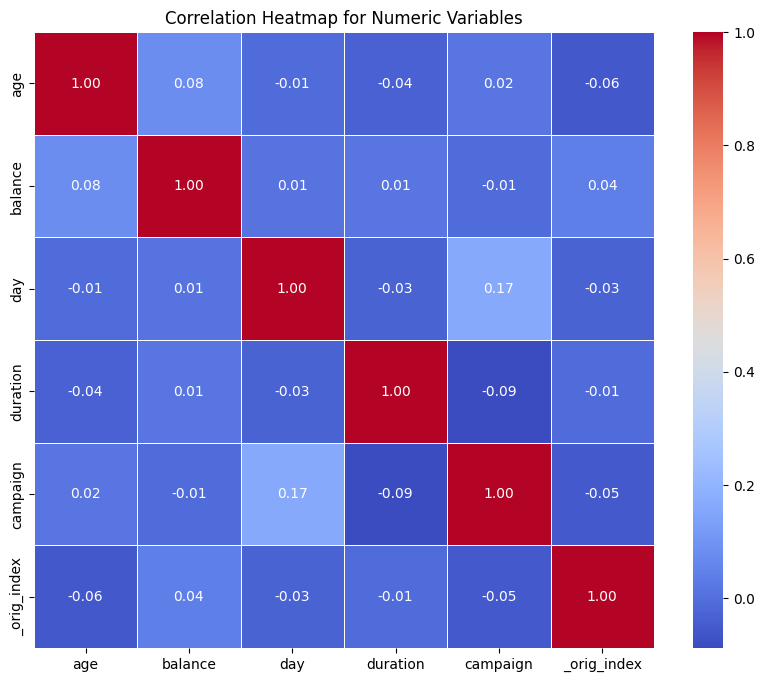

Dropping zero variance columns: ['const']
Final X shape before fit: (40000, 31)

=== FULL-SAMPLE REGRESSION RESULTS ===

--- LOGIT MODEL ---
AIC: 19582.5832
BIC: 19849.0789
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                40000
Model:                          Logit   Df Residuals:                    39969
Method:                           MLE   Df Model:                           30
Date:                Sat, 01 Nov 2025   Pseudo R-squ.:                 0.06080
Time:                        15:00:32   Log-Likelihood:                -9760.3
converged:                       True   LL-Null:                       -10392.
Covariance Type:            nonrobust   LLR p-value:                7.488e-247
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
age                

In [ ]:
#importing necessary libraries
import pandas as pd
import numpy as np
import warnings
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, log_loss,
    f1_score, precision_score, recall_score
)
from scipy.linalg import qr  # for QR with column pivoting



#Loading the base data
data = pd.read_csv('/Users/sarvagyasharma/Desktop/apziva projects/second project/term-deposit-marketing-2020.csv')

# Keep original index for later join
data['_orig_index'] = np.arange(len(data))

# Running basic checks for the day gain insights about the data and identify potential issues.
print(data.info())
print(data.describe().T)

categorical_cols_initial = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'y']
existing_cats = [c for c in categorical_cols_initial if c in data.columns]
if existing_cats:
    print(data[existing_cats].describe().T)

# If missing values exist, replace them with median for numeric columns and mode for categorical columns.
for col in data.columns:
    if col == 'y':
        continue
    missing_count = data[col].isnull().sum()
    if missing_count > 0:
        if pd.api.types.is_numeric_dtype(data[col]):
            median_value = data[col].median()
            data[col] = data[col].fillna(median_value)
            print(f"{col}: {missing_count} missing values replaced with median ({median_value})")
        else:
            mode_vals = data[col].mode(dropna=True)
            mode_value = mode_vals.iloc[0] if len(mode_vals) else 'missing'
            data[col] = data[col].fillna(mode_value)
            print(f"{col}: {missing_count} missing values replaced with mode ('{mode_value}')")
    else:
        print(f"{col}: No missing value")



# Correlation matrix for numeric variables to understand relationships and multicollinearity.
numeric_data = data.select_dtypes(include=['int64', 'float64', 'int32', 'float32'])
if not numeric_data.empty:
    corr_matrix = numeric_data.corr(numeric_only=True)
    print("CORRELATION MATRIX")
    print(corr_matrix)

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Heatmap for Numeric Variables')
    plt.show()
else:
    print("No numeric columns for correlation matrix")

#Threshold for classification
THRESHOLD = 0.2  



# Target to 0/1
if data['y'].dtype == object:
    data['y'] = data['y'].astype(str).str.strip().str.lower().map({'yes': 1, 'no': 0})
vals = set(data['y'].dropna().unique())
if not vals.issubset({0, 1}):
    raise ValueError(f"Target y must be binary 0/1, found {vals}")
y = data['y'].astype(int)



# Remove variables not known before calling: day, duration, campaign, contact
drop_features = {'y', 'day', 'duration', 'campaign', 'contact'}
feature_cols = [c for c in data.columns if c not in drop_features and c != '_orig_index']

num_cols = data[feature_cols].select_dtypes(include=['number']).columns.tolist()
cat_cols = data[feature_cols].select_dtypes(exclude=['number']).columns.tolist()


# One hot encoding of categorical variables.
X_num = data[num_cols].astype(float) if num_cols else pd.DataFrame(index=data.index)
X_cat = pd.get_dummies(
    data[cat_cols],
    drop_first=True,
    dtype=float,
    prefix=[c for c in cat_cols],
)
X = pd.concat([X_num, X_cat], axis=1)
X = sm.add_constant(X, has_constant='add')

# Clean X
X = X.replace([np.inf, -np.inf], np.nan).astype(float)
keep_rows = ~X.isnull().any(axis=1) & ~y.isnull()
if (~keep_rows).any():
    print(f"Dropping {(~keep_rows).sum()} rows due to NaN or Inf after encoding")
X, y = X.loc[keep_rows], y.loc[keep_rows]



# Identify binary dummy columns and numeric for later interpretation
def is_binary_series(s: pd.Series) -> bool:
    vals = pd.Series(s.dropna().unique())
    if len(vals) <= 2:
        return set(np.sort(vals.values).tolist()).issubset({0.0, 1.0})
    return False

binary_cols = [c for c in X.columns if c != 'const' and is_binary_series(X[c])]
numeric_cols_for_effects = [c for c in X.columns if c not in binary_cols and c != 'const']



#Drop zero variance columns 
var0_cols = [c for c in X.columns if X[c].nunique(dropna=False) <= 1]
if var0_cols:
    print(f"Dropping zero variance columns: {var0_cols}")
    X = X.drop(columns=var0_cols)



#Dropping perfectly collinear columns using QR with column pivoting
X_np = X.values
try:
    Q, R, P = qr(X_np, mode='economic', pivoting=True)
    diag = np.abs(np.diag(R))
    tol = np.finfo(float).eps * max(X_np.shape) * (diag.max() if diag.size > 0 else 1.0)
    rank = int((diag > tol).sum()) if diag.size > 0 else X_np.shape[1]
    keep_idx = sorted(P[:rank].tolist())
    drop_idx = sorted(set(range(X.shape[1])) - set(keep_idx))
    if drop_idx:
        drop_cols = X.columns[drop_idx].tolist()
        print(f"Dropping collinear columns: {drop_cols}")
        X = X.iloc[:, keep_idx]
except Exception as e:
    print(f"QR decomposition for collinearity pruning failed: {e}. Proceeding without this step.")



#Final clean and row filter
X = X.replace([np.inf, -np.inf], np.nan)
keep_final = ~X.isnull().any(axis=1) & ~y.isnull()
if (~keep_final).any():
    print(f"Dropping {(~keep_final).sum()} rows due to remaining NaN or Inf after pruning")
X, y = X.loc[keep_final], y.loc[keep_final]

print(f"Final X shape before fit: {X.shape}")

# Fit helpers
def safe_fit(model_type, X_df, y_series):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        if model_type == 'logit':
            model = sm.Logit(y_series, X_df)
        elif model_type == 'probit':
            model = sm.Probit(y_series, X_df)
        else:
            raise ValueError("model_type must be 'logit' or 'probit'")
        res = model.fit(disp=0)
        try:
            aic_val = res.aic
            bic_val = res.bic
        except Exception:
            aic_val = -2 * res.llf + 2 * res.df_model
            bic_val = -2 * res.llf + np.log(X_df.shape[0]) * res.df_model
        return res, aic_val, bic_val

def cv_with_threshold(model_type, X_df, y_series, n_splits=5, threshold=THRESHOLD, seed=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    metrics = {'accuracy': [], 'roc_auc': [], 'log_loss': [], 'f1': [], 'precision': [], 'recall': []}
    for tr, te in skf.split(X_df, y_series):
        X_tr, X_te = X_df.iloc[tr], X_df.iloc[te]
        y_tr, y_te = y_series.iloc[tr], y_series.iloc[te]
        res, _, _ = safe_fit(model_type, X_tr, y_tr)
        proba = res.predict(X_te)
        proba = np.clip(proba, 1e-6, 1 - 1e-6)
        pred = (proba >= threshold).astype(int)
        metrics['accuracy'].append(accuracy_score(y_te, pred))
        try:
            metrics['roc_auc'].append(roc_auc_score(y_te, proba))
        except ValueError:
            pass
        metrics['log_loss'].append(log_loss(y_te, proba))
        metrics['f1'].append(f1_score(y_te, pred, zero_division=0))
        metrics['precision'].append(precision_score(y_te, pred, zero_division=0))
        metrics['recall'].append(recall_score(y_te, pred, zero_division=0))
    return {k: {'mean': np.mean(v), 'std': np.std(v)} for k, v in metrics.items() if len(v) > 0}

#Regression results on full sample
print("\n=== FULL-SAMPLE REGRESSION RESULTS ===")
results = {}
abics = {}
for model_name in ['logit', 'probit']:
    res, aic_val, bic_val = safe_fit(model_name, X, y)
    results[model_name] = res
    abics[model_name] = (aic_val, bic_val)
    print(f"\n--- {model_name.upper()} MODEL ---")
    print(f"AIC: {aic_val:.4f}")
    print(f"BIC: {bic_val:.4f}")
    print(res.summary())

# Interpretation in percentage points for both logit and probit
def average_discrete_effect_for_dummy(res, X_df, varname):
    X0 = X_df.copy()
    X1 = X_df.copy()
    X0[varname] = 0.0
    X1[varname] = 1.0
    p0 = res.predict(X0)
    p1 = res.predict(X1)
    return float((p1 - p0).mean())

def print_interpretation_generic(res, X_df, title, numeric_cols_for_effects, binary_cols):
    print(f"\n=== INTERPRETATION IN PERCENTAGES ({title}) ===")
    pvals = res.pvalues
    sig_vars = [v for v in pvals.index if v != 'const' and pvals[v] < 0.10]
    if not sig_vars:
        print("No coefficients are significant at p < 0.10")
        return

    ame_map = {}
    try:
        mfx = res.get_margeff(at='overall', method='dydx')
        mf = mfx.summary_frame()
        if 'variable' in mf.columns:
            mf = mf.set_index('variable')
        col = 'dy/dx' if 'dy/dx' in mf.columns else mf.columns[0]
        for v in numeric_cols_for_effects:
            if v in mf.index and np.isfinite(mf.loc[v, col]):
                ame_map[v] = float(mf.loc[v, col])
    except Exception:
        pass

    rows = []
    for v in sig_vars:
        pval = float(pvals[v])
        if v in binary_cols:
            eff_pp = average_discrete_effect_for_dummy(res, X_df, v) * 100.0
            rows.append((v, 'binary 0→1', eff_pp, pval))
        elif v in numeric_cols_for_effects:
            eff_pp = ame_map.get(v, float('nan'))
            eff_pp = eff_pp * 100.0 if np.isfinite(eff_pp) else float('nan')
            rows.append((v, 'numeric per +1', eff_pp, pval))
        else:
            rows.append((v, 'unknown', float('nan'), pval))

    if rows:
        print("Variable".ljust(36), "Type".ljust(16), "Avg change in prob (pp)".ljust(24), "p-value")
        print("-"*95)
        for name, typ, pp, p in rows:
            pp_str = f"{pp:.2f}" if np.isfinite(pp) else "NA"
            print(name.ljust(36), typ.ljust(16), pp_str.ljust(24), f"{p:.3f}")

# Print interpretations
print_interpretation_generic(results['logit'], X, "LOGIT", numeric_cols_for_effects, binary_cols)
print_interpretation_generic(results['probit'], X, "PROBIT", numeric_cols_for_effects, binary_cols)

# 5 fold cross-validation at specified threshold
print(f"\n=== 5-FOLD CROSS VALIDATION (Threshold = {THRESHOLD}) ===")
for model_name in ['logit', 'probit']:
    cvres = cv_with_threshold(model_name, X, y, n_splits=5, threshold=THRESHOLD)
    print(f"\n--- {model_name.upper()} MODEL ---")
    for metric, stats in cvres.items():
        print(f"{metric}: mean={stats['mean']:.4f}  std={stats['std']:.4f}")

#Save sorted predicted probabilities to CSV.
model_for_scoring = 'logit' 
res_score = results[model_for_scoring]
proba_full = res_score.predict(X)

scored = data.loc[X.index, :].copy()
scored['predicted_prob'] = np.clip(proba_full, 1e-9, 1 - 1e-9)
scored_sorted = scored.sort_values('predicted_prob', ascending=False)

out_path = 'sorted_predicted_probabilities.csv'
scored_sorted.to_csv(out_path, index=False)
print(f"\nSaved sorted probabilities to: {out_path}")
